# EDA of the final dataset

Scanning dataset structure...
Total images found: 25981


,filepath,split,label
0,../data/processed/dataset_final\train\glioma\0...,train,glioma
1,../data/processed/dataset_final\train\glioma\0...,train,glioma
2,../data/processed/dataset_final\train\glioma\0...,train,glioma
3,../data/processed/dataset_final\train\glioma\0...,train,glioma
4,../data/processed/dataset_final\train\glioma\0...,train,glioma


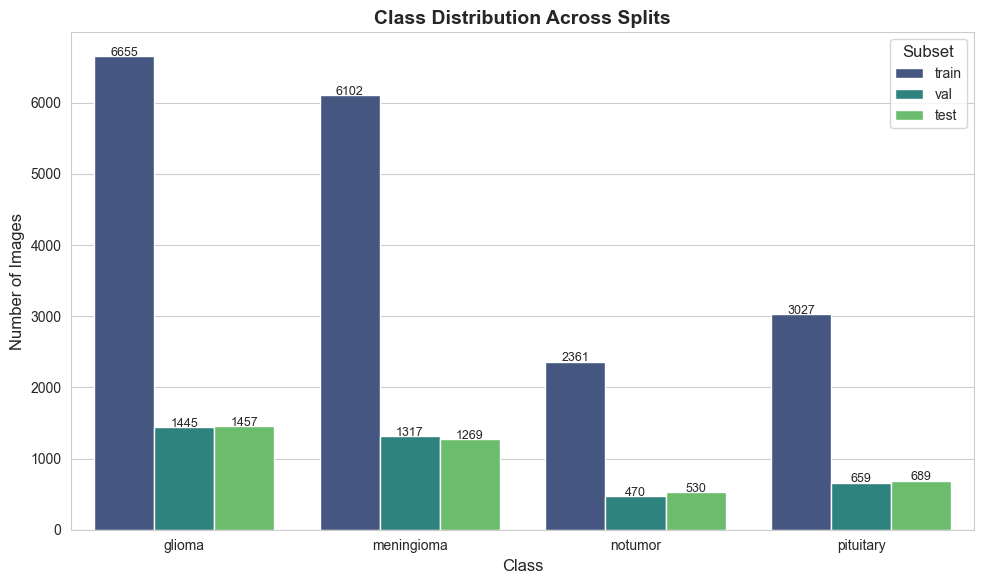

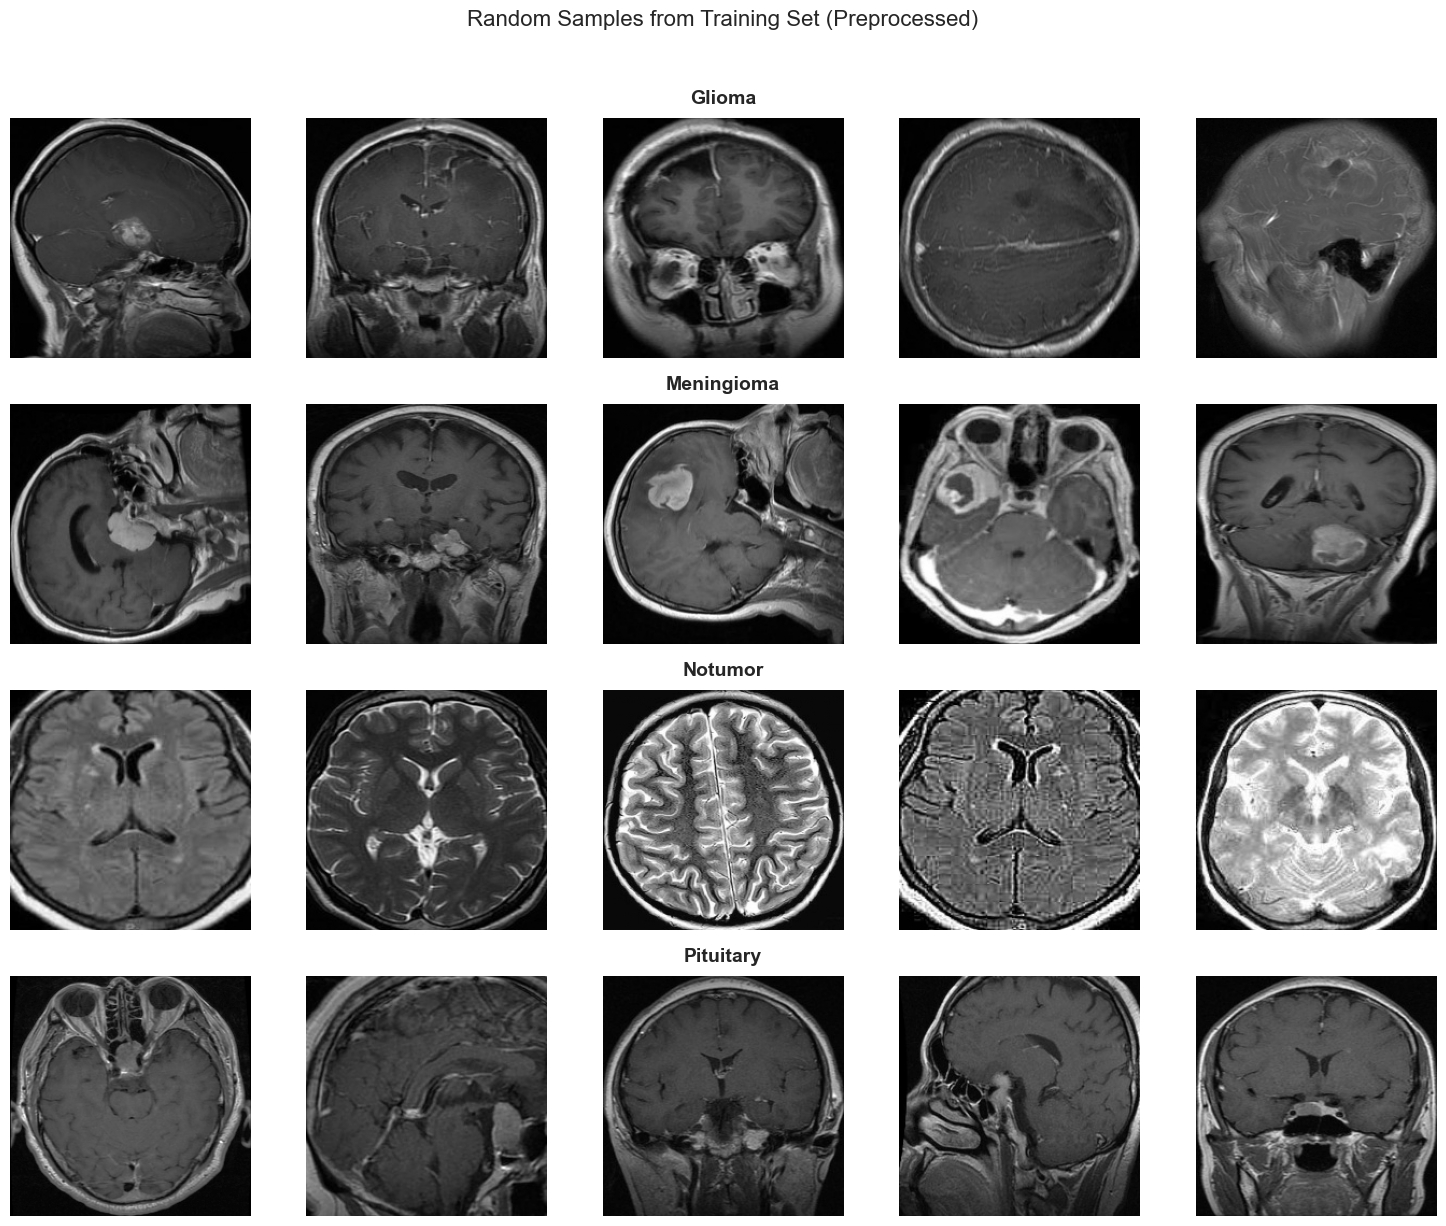

Calculating pixel intensities...


100%|██████████| 2000/2000 [00:20<00:00, 98.82it/s] 
C:\Users\emma\AppData\Local\Temp\ipykernel_16776\1718605326.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="label", y="mean_intensity", data=sample_df, palette="Set2")


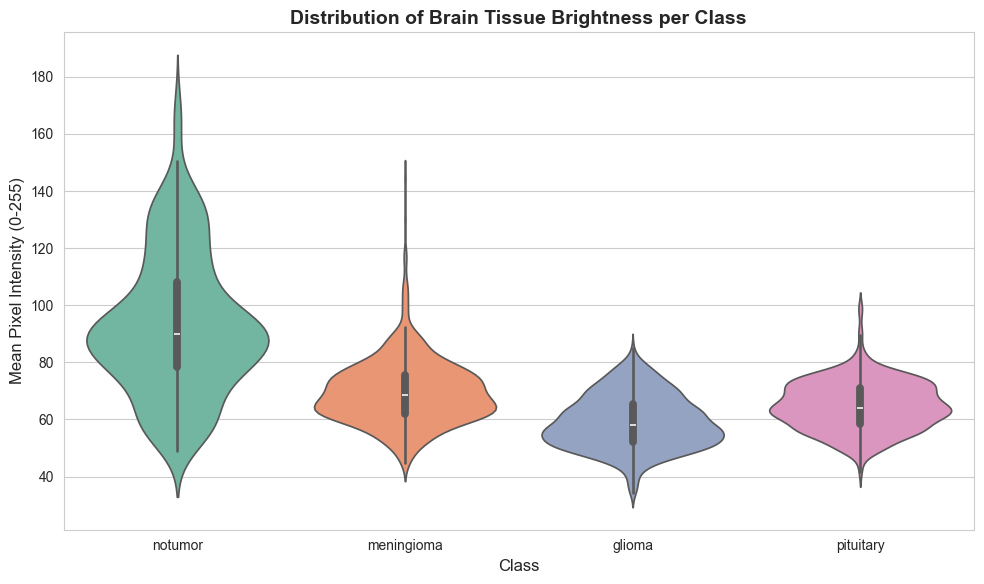

Computing average brains...


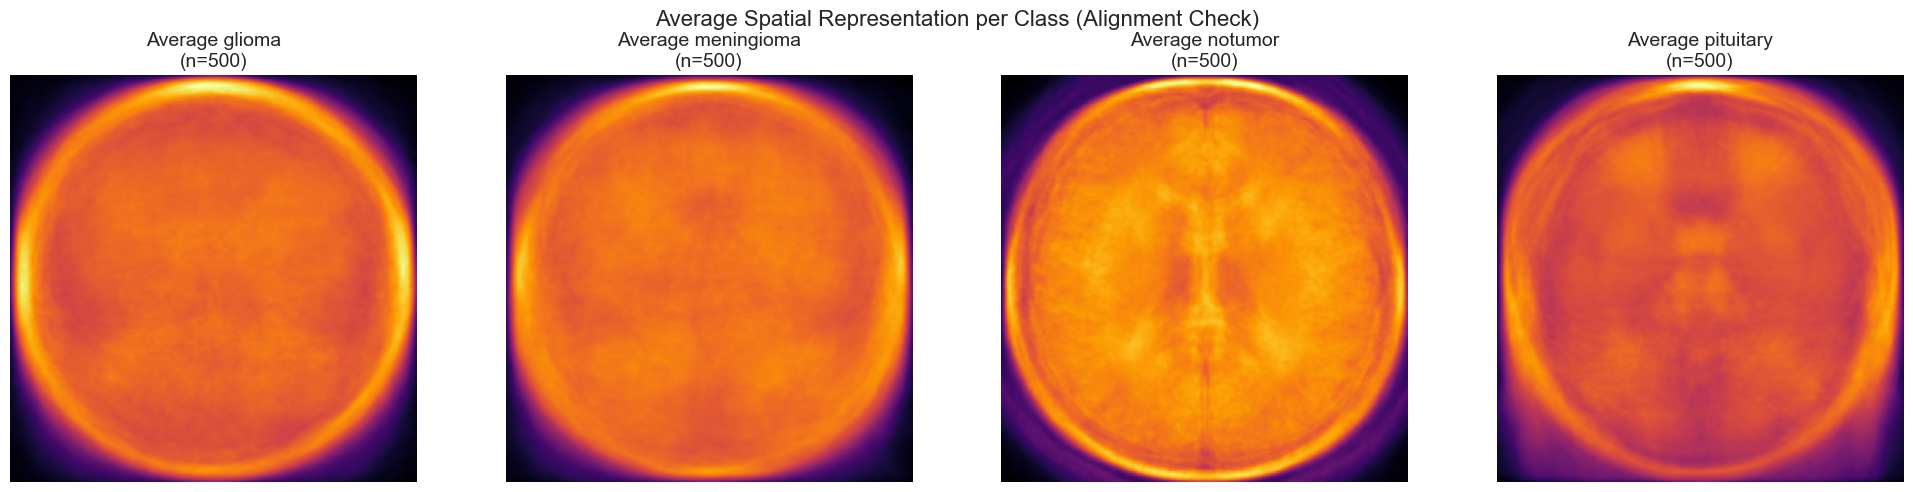

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm import tqdm

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

DATASET_PATH = "../data/processed/dataset_final" 

def build_metadata_dataframe(root_path):
    data = []
    splits = ['train', 'val', 'test']
    
    print("Scanning dataset structure...")
    for split in splits:
        split_path = os.path.join(root_path, split)
        if not os.path.exists(split_path):
            continue
            
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
        
        for label in classes:
            class_path = os.path.join(split_path, label)
            files = glob.glob(os.path.join(class_path, "*"))
            
            for f in files:
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    data.append({
                        'filepath': f,
                        'split': split,
                        'label': label
                    })
    
    return pd.DataFrame(data)

# Loading
df = build_metadata_dataframe(DATASET_PATH)
print(f"Total images found: {len(df)}")
display(df.head())

# Figure 1
def plot_distribution(df):
    plt.figure(figsize=(10, 6))
    
    order = sorted(df['label'].unique())
    palette = sns.color_palette("viridis", 3) 
    ax = sns.countplot(x="label", hue="split", data=df, order=order, palette=palette)
    
    plt.title("Class Distribution Across Splits", fontweight='bold')
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.legend(title="Subset")
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., height + 5, 
                    f'{int(height)}', ha="center", fontsize=9)
            
    plt.tight_layout()
    plt.savefig("figures/eda_class_distribution.png", dpi=300)
    plt.show()

plot_distribution(df)

# Figure 2
def plot_samples(df, n_samples=5):
    classes = sorted(df['label'].unique())
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(15, 3*len(classes)))
    
    for i, cls in enumerate(classes):
        subset = df[(df['label'] == cls) & (df['split'] == 'train')]
        samples = subset.sample(n_samples, random_state=42)['filepath'].values
        
        for j, img_path in enumerate(samples):
            img = cv2.imread(img_path)
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            axes[i, j].imshow(img, cmap='gray')
            if j == 2: 
                axes[i, j].set_title(cls.capitalize(), fontsize=14, fontweight='bold', pad=10)
            axes[i, j].axis('off')
            
    plt.suptitle("Random Samples from Training Set (Preprocessed)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig("figures/eda_visual_samples.png", dpi=300)
    plt.show()

plot_samples(df)


# Figure 3
def analyze_brightness(df):
    sample_df = df.sample(min(2000, len(df)), random_state=42).copy()
    
    intensities = []
    print("Calculating pixel intensities...")
    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            mask = img > 0
            if np.sum(mask) > 0:
                mean_val = img[mask].mean()
            else:
                mean_val = 0
            intensities.append(mean_val)
        else:
            intensities.append(None)
            
    sample_df['mean_intensity'] = intensities
    sample_df = sample_df.dropna()
    
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="label", y="mean_intensity", data=sample_df, palette="Set2")
    plt.title("Distribution of Brain Tissue Brightness per Class", fontweight='bold')
    plt.xlabel("Class")
    plt.ylabel("Mean Pixel Intensity (0-255)")
    
    plt.tight_layout()
    plt.savefig("figures/eda_brightness_bias.png", dpi=300)
    plt.show()

analyze_brightness(df)


# Figure 4
def plot_average_brains(df):
    classes = sorted(df['label'].unique())
    
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))
    
    print("Computing average brains...")
    
    for i, cls in enumerate(classes):
        subset = df[(df['label'] == cls) & (df['split'] == 'train')]
        paths = subset.sample(min(500, len(subset)), random_state=42)['filepath'].values
        
        img_sum = None
        count = 0
        
        for path in paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (224, 224)) 
                img = img.astype(float)
                
                if img_sum is None:
                    img_sum = img
                else:
                    img_sum += img
                count += 1
        
        if count > 0:
            avg_img = img_sum / count
            axes[i].imshow(avg_img, cmap='inferno') 
            axes[i].set_title(f"Average {cls}\n(n={count})")
            axes[i].axis('off')
            
    plt.suptitle("Average Spatial Representation per Class (Alignment Check)", fontsize=16)
    plt.tight_layout()
    plt.savefig("figures/eda_average_brains.png", dpi=300)
    plt.show()

plot_average_brains(df)